## Set Up API-KEYS

Tavily: [Get your API key](https://app.tavily.com/settings/api-keys)  
Google-Gemini: [Get your API key](https://aistudio.google.com/app/apikey)

In [ ]:
from dotenv import  load_dotenv
load_dotenv("../")



In [45]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [46]:
from typing import Literal, Annotated, Sequence, List
from langchain_core.messages import BaseMessage, HumanMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command 

# Define available agents
members = ["web_researcher", "rag", "nl2sql"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]

# Create system prompt for supervisor
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Each worker has access to specific tools. "
    "Based on the user's request, you must decide which worker should act next. "
    "If a worker needs to use a tool, clearly instruct them to do so. "
    "When the user's request is fully addressed, respond with FINISH."
)

# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["web_researcher", "rag", "nl2sql", "FINISH"]

# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)


In [47]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict  # Added
from langchain_core.messages import BaseMessage, SystemMessage  # Added SystemMessage, ensured BaseMessage
from langgraph.graph import StateGraph, add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]


def create_agent(llm, tools, agent_name: str):  # Added agent_name
    llm_with_tools = llm.bind_tools(tools)

    tool_descriptions = "\n".join([f"- {tool.name}: {getattr(tool, 'description', 'No description available')}" for tool in tools])
    agent_system_prompt_content = (
        f"You are the '{agent_name}'. Your primary goal is to assist based on the user's most recent request. "
        f"You have the following tools available:\n{tool_descriptions}\n\n"
        "Review the latest message in the conversation. If any of your tools are suitable for addressing it, "
        "you MUST invoke the tool with the correct arguments. "
    )

    def chatbot(state: AgentState):
        current_messages = list(state["messages"])
        agent_system_message = SystemMessage(content=agent_system_prompt_content)
        messages_for_llm = [agent_system_message] + current_messages
        response_message = llm_with_tools.invoke(messages_for_llm)
        return {"messages": [response_message]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)
    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()


## Tool Creation

### Web Search Tool

In [48]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(
    max_results=2,
    description="Tool to perform web search queries using Tavily."
)

In [49]:
web_search_tool.invoke("CEO GOOGLE")

[{'title': 'Sundar Pichai | Biography, Google, & Facts | Britannica Money',
  'url': 'https://www.britannica.com/money/Sundar-Pichai',
  'content': '**Sundar Pichai** (born June 10, 1972, Madras \\[now Chennai\\], [Tamil Nadu](https://www.britannica.com/place/Tamil-Nadu), India) is an Indian-born American executive who was [CEO](https://www.britannica.com/money/chief-executive-officer) of both [Google, Inc.](https://www.britannica.com/money/Google-Inc) (2015– ), and its [holding company](https://www.britannica.com/money/holding-company), Alphabet Inc. (2019– ).\n\nEarly life\n---------- [...] Page](https://www.britannica.com/money/Larry-Page) and [Sergey Brin](https://www.britannica.com/money/Sergey-Brin) announced the creation of Alphabet Inc., in August 2015, it came as no surprise to industry insiders that Pichai was named CEO of Google, which was reorganized as a subsidiary. In December 2019 he also was named CEO of [Alphabet](https://www.britannica.com/money/Alphabet-Inc), replaci

### RAG Tool

In [50]:
%pip install langchain-community docx2txt pypdf

import os
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

# folder_path is already defined above, so we use it directly
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")


Note: you may need to restart the kernel to use updated packages.
Unsupported file type: cat-facts.txt
Loaded 5 documents from the folder.


c:\Users\Harsh\_codes_\intership\RAG-Tutorials\.venv\Scripts\python.exe: No module named pip


In [51]:
 text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

 splits = text_splitter.split_documents(documents)
 print(f"Split the documents into {len(splits)} chunks.")


Split the documents into 5 chunks.


In [52]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding_function = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [53]:
 from langchain_chroma import Chroma

 collection_name = "my_collection"
 vectorstore = Chroma.from_documents(
     collection_name=collection_name,
     documents=splits,
     embedding=embedding_function,
     persist_directory="../db/chroma_db"
 )


In [54]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """Tool to Retrieve Semantically Similar documents to answer User Questions related to His company NOVA.
    This tool has access to data about the Nova company and details about it, so when the user asks, it can answer questions regarding Nova."""
    print("INSIDE RETRIEVER NODE")
    retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
    retriever_result = retriever.invoke(question)
    return "\n\n".join(doc.page_content for doc in retriever_result)


In [55]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
# pass question
retriever_results = retriever.invoke("What is transformers?")
print(retriever_results)


[Document(id='e30a0098-feb5-4070-90a4-30beb62c69e3', metadata={'page_label': '1', 'source': '../contents\\Nova_AI_Company_Profile.pdf', 'page': 0, 'creator': 'PyPDF', 'creationdate': 'D:20250606115713', 'total_pages': 5, 'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/'}, page_content='NOVA AI SOLUTIONS\nIntelligence Engineered for the Future\nwww.novaai.tech | contact@novaai.tech | +1 (555) 123-4567\nLinkedIn | Twitter | GitHub'), Document(id='1fec6a3e-a09a-498e-9cd6-e7d2d6350416', metadata={'creationdate': 'D:20250606115713', 'total_pages': 5, 'page': 2, 'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'source': '../contents\\Nova_AI_Company_Profile.pdf', 'page_label': '3', 'creator': 'PyPDF'}, page_content='Our Technology\nNova AI builds scalable, production-grade AI systems powered by the latest in:\n- Machine Learning (ML)\n- Natural Language Processing (NLP)\n- Computer Vision (CV)\n- Large Language Models (LLMs)\n- Real-time Predictive Analytics\nWe maintain an a

### NLSQL Tool

Run the db_setup.py to setup the database

In [79]:
 from langchain_community.utilities import SQLDatabase

 db = SQLDatabase.from_uri("sqlite:///../db/ecommerce.db")


In [57]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


In [74]:
 from langchain.chains import create_sql_query_chain
 from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
 from operator import itemgetter
 import re
 from langchain_core.output_parsers import StrOutputParser
 from langchain_core.prompts import PromptTemplate
 from langchain_core.runnables import RunnablePassthrough, RunnableLambda

 class SQLToolSchema(BaseModel):
     question: str

 @tool(args_schema=SQLToolSchema)
 def nl2sql_tool(question):
   """Tool to Generate and Execute SQL Query to answer User Questions related to an ecommerce store"""
   print("INSIDE NL2SQL TOOL")
   execute_query = QuerySQLDataBaseTool(db=db)
   write_query = create_sql_query_chain(llm, db)

   chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
   )

   response = chain.invoke({"question": question})
   return response['result']


In [ ]:
 question = "Most Expensive Order"
 result = nl2sql_tool.invoke({"question": question})
 print(f"Answer: {result}")


INSIDE NL2SQL TOOL
Answer: [(1, 5, '2023-07-07', 1057.84), (2, 7, '2023-02-01', 999.43), (3, 6, '2023-12-15', 3403.68), (4, 6, '2023-05-31', 2960.75), (5, 7, '2023-09-14', 641.42)]


## Agent Creation

In [60]:
websearch_agent = create_agent(llm, [web_search_tool], "Web Researcher Agent")

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [61]:
rag_agent = create_agent(llm, [retriever_tool], "RAG Agent")

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )


In [62]:
nl2sql_agent = create_agent(llm, [nl2sql_tool], "NL2SQL Agent")

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )


## Putting It All Together


In [63]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()


## Visualise the controlflow

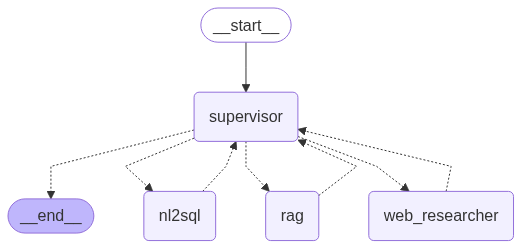

In [64]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass


## Testing


In [65]:
# Example: Complex Query Using Multiple Agents
input_question = "Find the founder of FutureSmart AI and then do a web research you can do it"
graph.invoke({"messages": [HumanMessage(content=input_question)]})

Next Worker: web_researcher
Next Worker: FINISH


{'messages': [HumanMessage(content='Find the founder of FutureSmart AI and then do a web research you can do it', additional_kwargs={}, response_metadata={}, id='4cd1d377-e3b1-4aac-b891-88525ddefe02'),
  HumanMessage(content="Based on my research, the founder of FutureSmart AI is Pradip Nichite.  He's also described as the CEO.", additional_kwargs={}, response_metadata={}, name='web_researcher', id='4f6f878f-63c5-4f3a-a780-d0be4e4ef7c8')]}

In [70]:
# Example: Complex Query Using Multiple Agents
input_question = "Most expensive order in database give accurately"
graph.invoke({"messages": [HumanMessage(content=input_question)]})

Next Worker: nl2sql
INSIDE NL2SQL TOOL
Next Worker: nl2sql


KeyboardInterrupt: 

In [67]:
# Example: Complex Query Using Multiple Agents
input_question = "Tell me about our team"
graph.invoke({"messages": [HumanMessage(content=input_question)]})

Next Worker: rag
INSIDE RETRIEVER NODE
Next Worker: FINISH


{'messages': [HumanMessage(content='Tell me about our team', additional_kwargs={}, response_metadata={}, id='6df777bf-ac12-4ffe-86cd-d32356b8e15d'),
  HumanMessage(content='Our team consists of Dr. Aisha Mehta, CEO; James Lin, CTO; and Radhika Rao, Head of Product.  We also have strategic partnerships with OpenAI, NVIDIA Inception Program, and AWS Activate.  Our contact information is available on our website, www.novaai.tech.', additional_kwargs={}, response_metadata={}, name='rag', id='5b64a4ab-46a7-4070-a889-2f4756b84515')]}